# Rasterize regions

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr 
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
tm = gpd.read_file('data/tmworld/tmworld-ms.shp')
tm.head()

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,"(POLYGON ((-61.686668 17.02444100000014, -61.7..."
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((9.537113 30.23439, 9.511388999999999..."
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,(POLYGON ((46.17824600000012 38.84114799999998...
3,AL,AL,ALB,8,Albania,2740,3153731,150,39,20.068,41.143,"POLYGON ((19.367771 41.848999, 19.34333 41.912..."
4,AM,AM,ARM,51,Armenia,2820,3017661,142,145,44.563,40.534,(POLYGON ((45.51305000000002 40.60721999999998...


In [5]:
# https://github.com/mathause/regionmask/issues/24#issue-274700026

from affine import Affine
from rasterio import features

def transform_from_latlon(lat, lon):
    '''perform an affine tranformation to the latitude/longitude coordinates'''
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale


def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=np.float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'), name='region')

In [7]:
# rasterize
NODATA = -9999
ENC = {k:{'dtype': 'int16', 'zlib': True, '_FillValue': NODATA} for k in ['UN', 'REGION', 'SUBREGION']}

with xr.open_dataset('area.nc')['area'] as ref:
    COORDS={'lon': ref.coords['lon'],'lat': ref.coords['lat']}

with xr.Dataset() as dsout:
    dsout['UN'] = rasterize(zip(tm.geometry, tm.UN), coords=COORDS)
    dsout['REGION'] = rasterize(zip(tm.geometry, tm.REGION), coords=COORDS)
    dsout['SUBREGION'] = rasterize(zip(tm.geometry, tm.SUBREGION), coords=COORDS)
    dsout.to_netcdf(f'data/tmworld_01deg.nc', encoding=ENC)


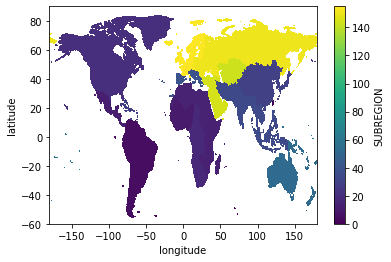

In [12]:
ds = xr.open_dataset("../tmworld/tmworld_MR.nc")
ds.SUBREGION.plot();